## Zonal

Xarray-spatial's zonal functions provide an easy way to generate statistics for zones within a raster aggregate. It's set up with a default set of calculations, or you can input any set of custom calculations you'd like to perform.

### Importing Packages

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

### Generate Terrain Data

The rest of the geo-related functions focus on raster data or data that's been aggregates into the row-column grid of cells for an image raster. To demonstrate using these raster-based functions, we'll first use xarray-spatial's generate_terrain to generate a fake elevation terrain raster. We use datashader's Canvas as a quick base to set up a new raster.

/home/giancastro/miniconda3/envs/xrspatial/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


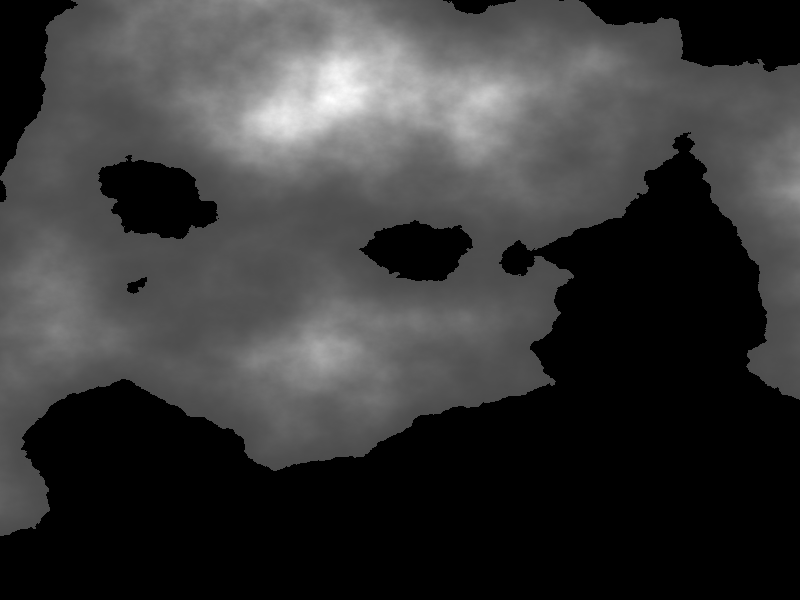

In [2]:
from xrspatial import generate_terrain

W = 800
H = 600

template_terrain = xr.DataArray(np.zeros((H, W)))
x_range = (-20e6, 20e6)
y_range = (-20e6, 20e6)

terrain = generate_terrain(template_terrain, x_range=x_range, y_range=y_range)

shade(terrain, cmap=["black", "white"], how="linear")

We can also apply datashader's Elevation colormap imported above to give a more intuitive terrain image.

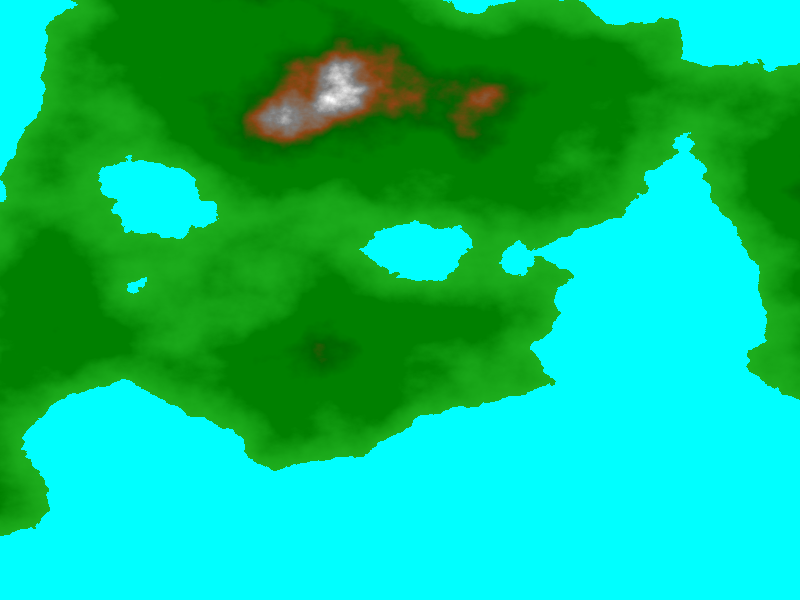

In [3]:
shade(terrain, cmap=Elevation, how="linear")

### Zonal Statistics

Zonal statistics calculates summary statistics for specific areas or zones within an xarray.DataArray aggregate. Specific zones within an aggregate are defined by creating a corresponding aggregate of the same shape and setting the value at each cell to a unique non-zero integer representing a unique zone id.

For example, if we set all the values in the top row of the zones aggregate to 3 and apply this to the original values aggregate, zonal stats will calculate statisitics for all the values in the corresponding top row of the values aggregate and return the results as stats for zone #3.

The output of zonal stats is in the form of a pandas DataFrame, with a row for each zone.

Let's set up an example.

Imagine you go on a six-day hike.

- We can represent the area with a terrain raster.
- In that terrain, we can represent each day's path as a line segment from your start to finish point.
- We can set this up with a pandas dataframe containing the start and finish points, which we then aggregate with Canvas.line.

Let's take a look at these line zones overlayed on the fake terrain.

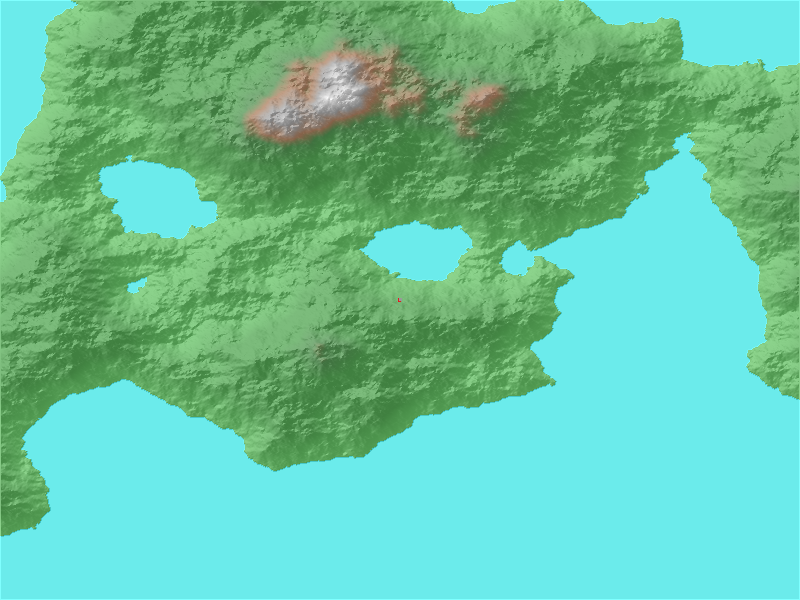

In [4]:
from xrspatial import hillshade
from datashader.colors import Set1

terrain_shaded = shade(terrain, cmap=Elevation, alpha=128, how="linear")

illuminated = hillshade(terrain)
illuminated_shaded = shade(illuminated, cmap=["gray", "white"], alpha=255, how="linear")

zone_df = pd.DataFrame(
    {
        "x": [-11, -5, 4, 12, 14, 18, 19],
        "y": [-5, 4, 10, 13, 13, 13, 10],
        "trail_segement_id": [11, 12, 13, 14, 15, 16, 17],
    }
)

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=x_range, y_range=y_range)

zones_agg = cvs.line(zone_df, "x", "y", ds.sum("trail_segement_id"))
zones_shaded = dynspread(shade(zones_agg, cmap=Set1), max_px=5)

stack(illuminated_shaded, terrain_shaded, zones_shaded)

Now, we can apply zonal stats, after quickly correcting for nan values.

In [5]:
from xrspatial import zonal_stats

zones_agg.values = np.nan_to_num(zones_agg.values, copy=False).astype(int)
zonal_stats(zones_agg, terrain)

,zone,mean,max,min,sum,std,var,count
0,0,888.487944,4000.000000,0.000000,4.264715e+08,872.385158,761055.863901,479997
1,11,1443.760982,1452.024715,1435.497249,2.887522e+03,8.263733,68.289285,2
2,70,1435.677678,1435.677678,1435.677678,1.435678e+03,0.000000,0.000000,1


#### Calculate custom stats for each zone

We can also put in our own set of stats calculations to perform instead of the default ones above. 
- We set up a dict with our desired functions and input that as the third argument to `zonal_stats`.
- Below, we try out a range function and min and max functions.

In [6]:
custom_stats = dict(
    elevation_change=lambda zone: zone.max() - zone.min(),
    elevation_min=np.min,
    elevation_max=np.max,
)

zonal_stats(zones=zones_agg, values=terrain, stats_funcs=custom_stats)

,zone,elevation_change,elevation_min,elevation_max
0,0,4000.000000,0.000000,4000.000000
1,11,16.527466,1435.497249,1452.024715
2,70,0.000000,1435.677678,1435.677678


Here the zones are defined by line segments, but they can be any spatial pattern or, more specifically, any region computable as a Datashader aggregate.